In [2]:
import numpy as np
import pandas as pd
import pyfolio as pf

from mlfinlab.corefns.core_functions import CoreFunctions
from mlfinlab.fracdiff.fracdiff import frac_diff_ffd

In [4]:
# Moving Average Strategy, no meta labeling
ma_side_strategy = pd.read_csv('ma_side.csv', index_col=0)
ma_side_strategy.index = pd.to_datetime(ma_side_strategy.index)
ma_side_strategy.head()

,return,trgt,trade,side,first_touch
2011-08-02 15:02:12.277,0.009338,0.008616,1,-1.0,2011-08-02 17:57:51.964
2011-08-02 16:48:53.474,0.008583,0.007736,1,-1.0,2011-08-02 19:52:57.011
2011-08-03 01:53:52.265,0.010746,0.008415,1,-1.0,2011-08-03 14:37:04.871
2011-08-03 08:02:36.120,0.010473,0.008016,1,-1.0,2011-08-03 14:23:36.205
2011-08-03 14:56:24.514,-0.017443,0.007678,0,-1.0,2011-08-04 01:57:00.466


## Returns Tearsheet

Start date,2011-08-02
End date,2015-07-09
Total months,56
,Backtest
Annual return,22.7%
Cumulative returns,161.0%
Annual volatility,23.1%
Sharpe ratio,1.00
Calmar ratio,0.47
Stability,0.73
Max drawdown,-47.9%


/home/ariadne/anaconda3/envs/mlfinlab/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,47.87,2011-08-08,2011-08-11,2011-09-23,34
1,36.52,2011-10-12,2011-10-26,NaT,NaN
2,21.15,2011-08-05,2011-08-05,2011-08-08,2
3,14.43,2011-10-03,2011-10-04,2011-10-05,2
4,11.92,2011-08-03,2011-08-04,2011-08-04,2


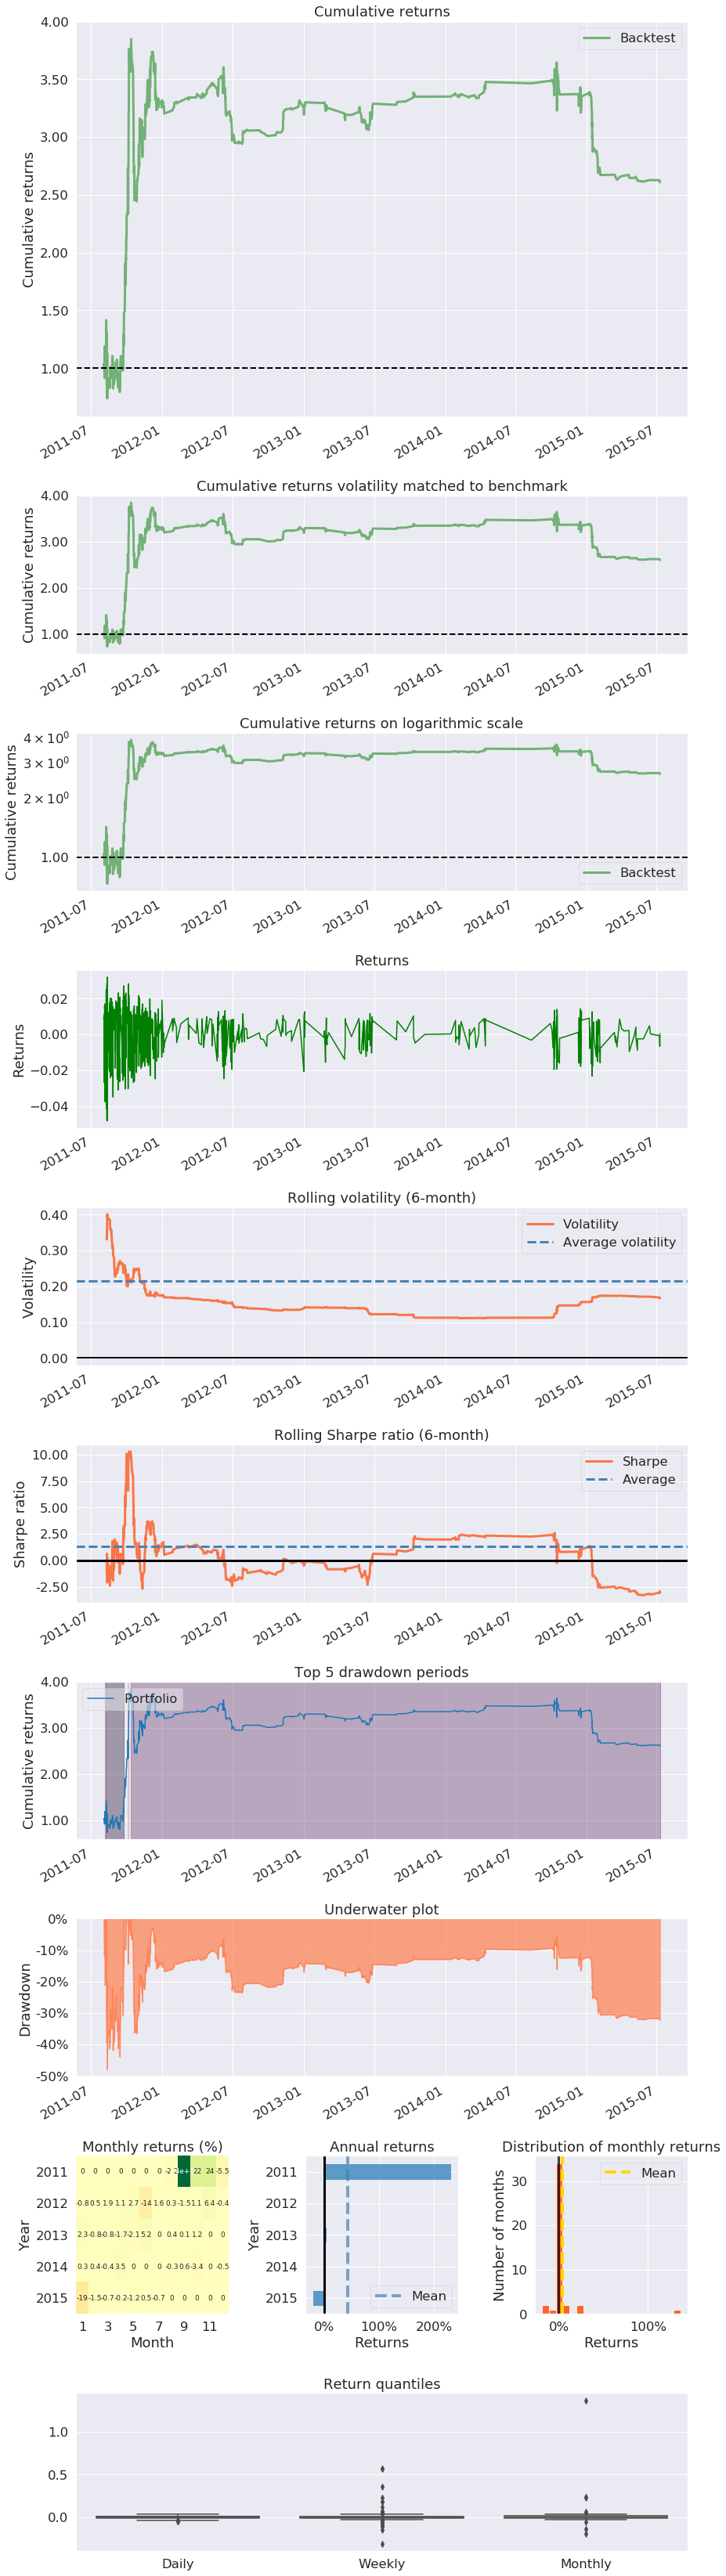

In [3]:
pf.create_returns_tear_sheet(ma_side_strategy['rets'], benchmark_rets=None)

---
## Primary Model Performance

In [4]:
from sklearn.metrics import roc_curve, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Get actual vs pred for primary model
actual = []
pred = []
for row in ma_side_strategy.itertuples():
    ret = row.rets
    side = row.side
    
    if ret > 0:
        actual.append(side)
    else:
        actual.append(side * -1.0)
        
    pred.append(side)

In [6]:
print('Primary model results')
print(classification_report(actual, pred))
confusion_matrix(y_true=actual, y_pred=pred)

Primary model results
              precision    recall  f1-score   support

        -1.0       0.56      0.62      0.59       549
         1.0       0.64      0.58      0.61       632

   micro avg       0.60      0.60      0.60      1181
   macro avg       0.60      0.60      0.60      1181
weighted avg       0.60      0.60      0.60      1181



array([[340, 209],
       [265, 367]])

## Secondary Model (Meta Labels)
**(3.4b) Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)**

In [7]:
close_prices = pd.read_csv('ma_close_prices.csv', header=None, index_col=0)
close_prices.columns = ['close']
close_prices.index = pd.to_datetime(close_prices.index)

In [20]:
# compute auto-correlation
auto_corr = CoreFunctions.get_autocorr(close_prices)
print(len(auto_corr))

# compute fractionally differentiated prices
from statsmodels.tsa.stattools import adfuller

fracs = frac_diff_ffd(close_prices.apply(np.log), differencing_amt=0.39, threshold=1e-5)
frac_df = pd.Series(index=close_prices.index, data=fracs).rename('fracdiff')

Calculating Daily AutoCorr
39945


In [27]:
# Create feature matrix
X = pd.DataFrame(ma_side_strategy['trgt'])
X['side'] = [ma_side_strategy['side'][x] for x in X.index]
X['autocorr'] = [auto_corr[x] for x in X.index]
X['fracdiff'] = [frac_df[x] for x in X.index]
print(X.tail())

# extract y values
y = ma_side_strategy.trade.to_frame()

KeyError: Timestamp('2011-08-02 15:02:12.277000')

In [22]:
X.bfill(inplace=True)

In [ ]:
X.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# RF Model
n_estimator = 10000
c_random_state = 42

rf = RandomForestClassifier(max_depth=4, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())

#### Training Metrics

In [ ]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Test Metrics

In [ ]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()